In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

import sys
print (sys.version) 

import statsmodels.api as sm  
sns.set_style('darkgrid')

import warnings
warnings.filterwarnings("ignore")


3.6.1 |Anaconda custom (x86_64)| (default, May 11 2017, 13:04:09) 
[GCC 4.2.1 Compatible Apple LLVM 6.0 (clang-600.0.57)]


/Users/mikeludwig/anaconda3/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [2]:
!python --version

Python 3.6.1 :: Anaconda custom (x86_64)


In [3]:
%%time
df = pd.read_excel('/Users/mikeludwig/Dropbox/city_data/Anonymized_20161006_DOT_Labor_for_PY_2011-12_to_2016-17_PP06_Ending_09172016.xlsx')


CPU times: user 5min 46s, sys: 25.8 s, total: 6min 12s
Wall time: 7min 42s


In [4]:
# %%writefile /Users/mikeludwig/Code/over_time/overtime-analysis/app_test.py

# Copyright 2017, Mike Ludwig, All rights reserved.
import config
aws_access_key_id = config.aws_access_key_id
aws_secret_access_key = config.aws_secret_access_key


SENDGRID_API_KEY = config.SENDGRID_API_KEY

template_id = config.template_id

# %matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import random
import datetime

import sys
print (sys.version) 

import statsmodels.api as sm  
sns.set_style('darkgrid')


import sendgrid
import os
from sendgrid.helpers.mail import *
import base64
import time
import io
import matplotlib.dates as mdates
import boto
from datetime import timedelta, date
from boto.s3.connection import S3Connection

seq_col_brew = sns.color_palette('Set2')
sns.set_palette(seq_col_brew)


def emps_morethan_std(df, jobtitle, workdate, varcode):
    #use masks
    jobtitle_mask = (df['JOB_CLASS_TITLE']== jobtitle)
    workdate_mask = (df['WORK_DATE']== workdate)
    varcode_mask = (df['Var Code']== varcode)
    new_df = df[jobtitle_mask & workdate_mask & varcode_mask]
    return new_df[(new_df.HOURS- new_df.HOURS.mean())>(new_df.HOURS.std())][['WORK_DATE', 'EMPLOYEE_NAME', 'HOURS']]

def daterange(start_date, end_date):
    for n in range(int ((end_date - start_date).days)+1):
        yield start_date + timedelta(n)

def more_than_std_in_range(df, jobtitle, start_date, end_date, varcode):
    appended_data = []
    for single_date in daterange(start_date, end_date):
        data = (emps_morethan_std(df, jobtitle, single_date, varcode))
        appended_data.append(data)
    return pd.concat(appended_data).reset_index(drop=True)

def get_everybody_in(df, jobtitle, start_date, end_date, varcode):
    jobtitle_mask = (df['JOB_CLASS_TITLE']== jobtitle)
    workdate_mask = (df['WORK_DATE'].isin(pd.date_range(start_date, end_date)))
    varcode_mask = (df['Var Code']== varcode)
    new_df = df[jobtitle_mask & workdate_mask & varcode_mask]
    return new_df


def assign_colors(df):
    names_group = df.groupby('EMPLOYEE_NAME')['HOURS'].sum().sort_values(ascending = False)
    names_list = names_group.index.get_level_values(0).tolist()
    return names_list 


# def mean_n_outliers_plot(main_df, outlier_df, color_names):
#     n = len(color_names)
#     sns.set_palette(sns.color_palette('RdBu', n))
#     g = sns.FacetGrid(outlier_df, hue='EMPLOYEE_NAME', hue_order=color_names, size=5.5)
#     g.map(plt.plot, 'WORK_DATE', 'HOURS', marker = 'o', linestyle = 'None').add_legend()
#     g.ax.set_title('OVERTIME HOURS BY PAY PERIOD')
#     g.ax.xaxis.set_major_locator(mdates.DayLocator())
#     g.ax.xaxis.set_major_formatter(mdates.DateFormatter('%m.%d.%Y'))
#     for item in g.ax.get_xticklabels():
#         item.set_rotation(45)
#     roll = main_df.groupby('WORK_DATE')['HOURS']
#     m = roll.agg(['mean', 'std'])
#     ax = m['mean'].plot()
#     ax.fill_between(m.index, m['mean'] - m['std'], m['mean'] + m['std'], alpha=.25)
#     plt.tight_layout()
#     g.add_legend()
#     ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.05),
#           ncol=3, fancybox=True, shadow=True)
#     sns.despine()

def mean_n_outliers_plot(main_df, outlier_df, color_names):
    n = len(color_names)
    sns.set_palette(sns.color_palette('RdBu', n))
#     sns.set_context('talk')
    g = sns.FacetGrid(outlier_df, hue='EMPLOYEE_NAME', hue_order=color_names, legend_out=True, size = 8, aspect = 2)
    g.map(plt.plot, 'WORK_DATE', 'HOURS', marker = 'o', linestyle = 'None')
    g.ax.set_title('OVERTIME HOURS BY PAY PERIOD')
    g.ax.xaxis.set_major_locator(mdates.DayLocator())
    g.ax.xaxis.set_major_formatter(mdates.DateFormatter('%m.%d.%Y'))
    for item in g.ax.get_xticklabels():
        item.set_rotation(45)
    roll = main_df.groupby('WORK_DATE')['HOURS']
    m = roll.agg(['mean', 'std'])
    ax = m['mean'].plot()
    ax.fill_between(m.index, m['mean'] - m['std'], m['mean'] + m['std'], alpha=.25)
    plt.tight_layout()
    sns.plt.legend(loc='lower left', ncol=4, bbox_to_anchor=(-.05,-.5), title="Employee Name", fontsize=16)
    sns.despine()

    
def get_last_13_mos(df, jobtitle, start_date, end_date, varcode):
    new_start = end_date - pd.Timedelta(days=395)
    new_df = get_everybody_in(df, jobtitle, new_start, end_date, varcode).reset_index(drop=True)
    new_df.index = new_df['WORK_DATE']
    del new_df['WORK_DATE']
    month_mean_df = new_df.resample("M", closed='left', label = 'left').mean()
    month_total_df = new_df.resample("M", closed='left', label = 'left').sum()
    return [month_mean_df['HOURS'], month_total_df['HOURS']]



def plot_13mo_mean_n_total(mean_13_months_df, total_13_months_df):
    fig = plt.figure()
    fig.suptitle("Overtime for the Past 13 Months", fontsize=16)
    ax1 = fig.add_subplot(211)
    ax1.plot(mean_13_months_df,  marker = 's')
    ax1.set_title('MEAN HOURS')
    ax1.xaxis.set_major_locator(mdates.MonthLocator())
    ax1.xaxis.set_major_formatter(mdates.DateFormatter('%m.%d.%Y'))
    for item in ax1.get_xticklabels():
        item.set_rotation(45)
    ax1.figure.autofmt_xdate()
    fig.subplots_adjust(hspace=3.5)
    ax2 = fig.add_subplot(212)
    ax2.plot(total_13_months_df,  marker = 's') 
    ax2.set_title('TOTAL HOURS')
    ax2.xaxis.set_major_locator(mdates.MonthLocator())
    ax2.xaxis.set_major_formatter(mdates.DateFormatter('%m.%d.%Y'))
    for item in ax2.get_xticklabels():
        item.set_rotation(45)
    ax2.figure.autofmt_xdate()
    plt.tight_layout(h_pad=1.0)
    fig.subplots_adjust(top=0.88)
    sns.despine()

    
def get_mplusstd(df, jobtitle, start_date, end_date, varcode):
    new_start = end_date - pd.Timedelta(days=195)
    new_df = get_everybody_in(df, jobtitle, new_start, end_date, varcode).reset_index(drop=True)
    new_df.index = new_df['WORK_DATE']
    del new_df['WORK_DATE']
    roll = new_df.groupby('WORK_DATE')['HOURS']
    m = roll.agg(['mean', 'std'])
    return m['mean'] + m['std']




def plot_mplusstd(test_df, order_vars, seasonal_vars):
    fig= plt.figure(figsize=(10, 6))
    
    fig.suptitle("Overtime Hours for the Past 6 Months", fontsize=18)
    ax1 = fig.add_subplot(211)
    results = get_fitted_model(test_df, order_vars, seasonal_vars)
    pred_uc = results.get_forecast(steps=14)
    pred_ci = pred_uc.conf_int()
    ax1.plot(test_df)
    pred_uc.predicted_mean.plot(ax=ax1, label='Forecast', linewidth = 2.2)
    ax1.fill_between(pred_ci.index,
                       pred_ci.iloc[:, 0],
                        pred_ci.iloc[:, 1], color='k', alpha=.25)
    ax1.set_title('MEAN HOURS + ONE STANDARD DEVIATION')
    ax1.xaxis.set_major_locator(mdates.MonthLocator())
    ax1.xaxis.set_major_formatter(mdates.DateFormatter('%m.%d.%Y'))
    for item in ax1.get_xticklabels():
        item.set_rotation(45)
    ax1.figure.autofmt_xdate()
    plt.tight_layout()
    fig.subplots_adjust(top=0.88)
    sns.despine()
    
      
def plot_increasing_more_than_std(data, color):  
    data = clean_for_time(data)
    observed_dates = data.index.asi8
    observed_values = data['HOURS']
    predict_dates = pd.date_range(data.index[0], 
                                  data.index[0] + pd.DateOffset(days=28), 
                                  freq="D")
    model = np.polyfit(observed_dates, observed_values, 1)
    predicted = np.polyval(model, predict_dates.asi8)
    plt.plot(data.index, data['HOURS'], marker='o', label = 'Overtime')
    plt.plot(predict_dates, predicted, 'b', linewidth=2, label = 'Trend Line')
   
    
def make_increasing_plot(df, trending_list):
    new_df = df[df['EMPLOYEE_NAME'].isin(trending_list)]
    g = sns.FacetGrid(new_df, col="EMPLOYEE_NAME", size=3, aspect=2, col_wrap=3)
    g.map_dataframe(plot_increasing_more_than_std)
    r_baseline = df['HOURS'].mean() + df['HOURS'].std()
    for ax in g.axes.ravel():
        ax.axhline(y=r_baseline, color = 'r', linestyle='dashed',  label='Group Mean Range for Pay Period')
    plt.tight_layout()
    sns.despine()
    
def clean_for_time(df):
    new_df = df.set_index('WORK_DATE')
    new_df = new_df.groupby(new_df.index).agg({'EMPLOYEE_NAME': 'first',
                                'HOURS': 'sum'})
    return new_df.asfreq("D", method='bfill')

def plot_hours_dist(df):
    sns.distplot(df['HOURS'])
    plt.axvline(x= df['HOURS'].mean(), color = 'k')
    plt.axvline(x= df['HOURS'].mean() + df['HOURS'].std(), linestyle = 'dashed', color = 'b')
    plt.axvline(x= df['HOURS'].mean() - df['HOURS'].std(), linestyle = 'dashed', color = 'b')
    
def plot_bars_highOT(outlier_df, color_names):
    n = len(color_names)
    sns.set_palette(sns.color_palette('RdYlBu', n))
    fig = plt.figure(figsize = (7,6))
    df2 = outlier_df.groupby('EMPLOYEE_NAME')['HOURS'].sum().sort_values(ascending = False)
    ax = sns.barplot(y = 'EMPLOYEE_NAME', x = 'HOURS',  data=df2.reset_index())
    ax.set(xlabel='Total Hours', ylabel='Employee Name')
    fig.suptitle('Highest Overtime Users for the Past Pay Period')
    plt.tight_layout(h_pad=1.0)
    fig.subplots_adjust(top=0.88)
    sns.despine()


def run_analysis(df, job_title, start_date, end_date, var_code):
    #use masks to create filtered dataframe, 
    outlier_df = more_than_std_in_range(df, job_title, start_date, end_date, var_code)
    relevant_df = get_everybody_in(df, job_title, start_date, end_date, var_code).reset_index(drop=True)
#     trend_high_list = is_trending_too_high(relevant_df)
    color_names = assign_colors(outlier_df)
    mean_n_outliers_plot(relevant_df, outlier_df, color_names)
    plt.savefig('means_n_outliers.png', format='png', bbox_inches='tight')
    # *save_to_s3('means_n_outliers', job_title, end_date)
    test_df = get_mplusstd(df, a, start_date, end_date, b)
    plot_mplusstd(test_df,  order_vars =(1, 0, 1), seasonal_vars =(1, 1, 1, 7))
    plt.savefig('13mo_mean_n_total.png', format='png', bbox_inches='tight')
    # *save_to_s3('13mo_mean_n_total', job_title, end_date)
    increase_list = is_trending_too_high(df, relevant_df, order_vars = (1, 1, 1),
                                         seasonal_vars = (1, 1, 1, 7))
    generate_plot(increase_list, end_date, df, order_vars = (1, 1, 1),
                                         seasonal_vars = (1, 1, 1, 7))
    plt.savefig('is_increasing.png', format='png', bbox_inches='tight')
    # *save_to_s3('is_increasing', job_title, end_date)
    plot_bars_highOT(outlier_df, color_names)
    plt.savefig('hours_dist.png', format='png', bbox_inches='tight')
    # *save_to_s3('hours_dist', job_title, end_date)

def save_to_s3(name, job_title, end_date):  
    img_data = io.BytesIO()
    plt.savefig(img_data, format='png', bbox_inches='tight')
    img_data.seek(0) 
    s3 = boto.connect_s3(aws_access_key_id, aws_secret_access_key)
    bucket = s3.get_bucket('mikes-charts')
    file_name = job_title.lower().replace(" ", "_")
    time_email = time.strftime("%Y%m%d")
    time_created = end_date.strftime("%Y%m%d")
    key = bucket.new_key(file_name + '/'+ time_email + '/'+ time_created +'/'+ name + '.png')
    key.set_contents_from_file(img_data, headers = {'Content-Disposition':'inline'})
    key.set_canned_acl('public-read')
    plt.close()  
    

def send_email(SENDGRID_API_KEY, template_id, job_title, end_date):
#     replacement_url = 'https://s3-us-west-1.amazonaws.com/mikes-charts/examples/controller_logo_med'
#     yrplus_mean_n_total_url, hours_dist_url, is_increasing_url, means_n_outliers_url  = get_urls_from_s3(job_title, end_date)
    sg = sendgrid.SendGridAPIClient(apikey = SENDGRID_API_KEY)
    from_email = Email("test@example.com")
    typed_email_address = input('Send email to what address?  --> ')
    to_email = Email(typed_email_address)
    subject = "This is a test"
    content = Content("text/html", "Let's see if this works!")
    mail = Mail(from_email, subject, to_email, content)
    mail.template_id = template_id
#     mail.personalizations[0].add_substitution(Substitution('~city_logo~', replacement_url))
#     mail.personalizations[0].add_substitution(Substitution('~means_n_outliers~', means_n_outliers_url))
#     mail.personalizations[0].add_substitution(Substitution('~13mo_mean_n_total~', yrplus_mean_n_total_url))
#     mail.personalizations[0].add_substitution(Substitution('~is_increasing~', is_increasing_url))
#     mail.personalizations[0].add_substitution(Substitution('~hours_dist~',  hours_dist_url))
    response = sg.client.mail.send.post(request_body=mail.get())
    print(response.status_code)
    print(response.body)
    print(response.headers)

    
def get_prefix(job_title, end_date):
    file_name = job_title.lower().replace(" ", "_")
    time_email = time.strftime("%Y%m%d")
    time_created = end_date.strftime("%Y%m%d")
    return (file_name + '/'+ time_email + '/'+ time_created +'/')

def get_urls_from_s3(job_title, end_date):
    conn = boto.connect_s3(aws_access_key_id, aws_secret_access_key)
    bucket = conn.get_bucket('mikes-charts')
    url_list = []
    folder_name = get_prefix(job_title, end_date)
    bucket_entries = bucket.list(prefix= folder_name)
    for entry in bucket_entries:
        url = entry.generate_url(expires_in=0, query_auth=False, force_http=True)
        url_list.append(url)
    return url_list

# create function accepting a single parameter, the year as a four digit number
def get_random_date(year):
    # try to get a date
    try:
        return datetime.datetime.strptime('{} {}'.format(random.randint(1, 366), year), '%j %Y')

    # if the value happens to be in the leap year range, try again
    except ValueError:
        get_random_date(year)
        
seq_col_brew = sns.color_palette('Set2')
sns.set_palette(seq_col_brew)


def plot_hours_dist(df):
    seq_col_brew = sns.color_palette('Set2')
    sns.set_palette(seq_col_brew)
    sns.distplot(df['HOURS'])
    plt.axvline(x= df['HOURS'].mean(), color = 'k')
    plt.axvline(x= df['HOURS'].mean() + df['HOURS'].std(), linestyle = 'dashed', color = 'b')
    plt.axvline(x= df['HOURS'].mean() - df['HOURS'].std(), linestyle = 'dashed', color = 'b')

# relevant_df['HOURS']

def add_in_data(df, end_date):
    start = df.index.min().date() 
    end = end_date + pd.Timedelta(1, 'D')
    return df.reindex(pd.date_range(start, end, freq='D', closed='left')).fillna(method='ffill')


def get_baseline(df, relevant_df, relevant_end_date):
    job_class = relevant_df['JOB_CLASS_TITLE'][0]
    var_code = relevant_df['Var Code'][0]
    jobclass_df = df[(df['JOB_CLASS_TITLE']==job_class) & (df['Var Code']== var_code) & (df['WORK_DATE']<=relevant_end_date)].groupby('WORK_DATE')
    jobclass_mean = jobclass_df['HOURS'].mean()
    jobclass_std = jobclass_df['HOURS'].std()
    jobclass_mstd = jobclass_mean+jobclass_std
    jobclass_mstd = jobclass_mstd[jobclass_mstd.notnull()]
    return jobclass_mstd.asfreq("D", method='bfill')
    
    

def get_fitted_model(tseries, order_vars, seasonal_vars):
    mod = sm.tsa.statespace.SARIMAX(tseries,
                                order = order_vars,
                                seasonal_order = seasonal_vars,
                                enforce_stationarity=False,
                                enforce_invertibility=False)

    return mod.fit()

# def is_trending_too_high(df, relevant_df, order_vars, seasonal_vars):
#     #use masks to create filtered dataframe
#     relevant_names = relevant_df['EMPLOYEE_NAME'].unique()
#     relevant_end_date = relevant_df['WORK_DATE'].max().date()
#     better_df = df[df['EMPLOYEE_NAME'].isin(relevant_names)]
#     better_df = better_df[better_df['WORK_DATE']<=relevant_end_date]
#     grps = better_df.groupby(['EMPLOYEE_NAME'])
#     baseline = get_baseline(df, relevant_df, relevant_end_date)
#     base_pred = get_fitted_model(baseline, order_vars, seasonal_vars).forecast(steps = 14)
#     increase_list = []
#     for fid, grp in grps:
#         if len(grp)>2:
#             new_df = clean_for_time(grp)
#             new_df = add_in_data(new_df, relevant_end_date)
#             results = get_fitted_model(new_df['HOURS'], order_vars, seasonal_vars)
#             pred = results.forecast(steps=14)
#             if np.all(pred > base_pred):
#                 increase_list.append(fid)
#     return increase_list

def filter_increasing(df, increase_list, start_date, end_date, job_title, var_code):
    increase_mask = (df['EMPLOYEE_NAME'].isin(increase_list))
    date_mask = (df['WORK_DATE']<=end_date) & (df['WORK_DATE']>=start_date)
    var_mask = (df['Var Code']== var_code)
    data = df[increase_mask & date_mask & var_mask]
    g = data.groupby('EMPLOYEE_NAME').filter(lambda x: len(x) > 5)
    return g['EMPLOYEE_NAME'].unique().tolist()



def is_trending_too_high(df, relevant_df, order_vars, seasonal_vars):
    relevant_names = relevant_df['EMPLOYEE_NAME'].unique()
    relevant_end_date = relevant_df['WORK_DATE'].max().date()
    rel_earlier_date = relevant_end_date -  pd.Timedelta(194, 'D')
    job_class = relevant_df['JOB_CLASS_TITLE'][0]
    var_code =  relevant_df['Var Code'][0]
    best_names = filter_increasing(df, relevant_names, rel_earlier_date, relevant_end_date, job_class, var_code)
    better_df = df[df['EMPLOYEE_NAME'].isin(best_names)]
    better_df = better_df[better_df['WORK_DATE']<=relevant_end_date]
    grps = better_df.groupby(['EMPLOYEE_NAME'])
    baseline = get_baseline(df, relevant_df, relevant_end_date)
    base_pred = get_fitted_model(baseline, order_vars, seasonal_vars).forecast(steps = 14)
    increase_list = []
    for fid, grp in grps:
        if len(grp)>2:
            new_df = clean_for_time(grp)
            new_df = add_in_data(new_df, relevant_end_date)
            results = get_fitted_model(new_df['HOURS'], order_vars, seasonal_vars)
            pred = results.forecast(steps=14)
            if np.all(pred > base_pred):
                increase_list.append(fid)
    return increase_list
  

    
def get_employee_OT(emp_name):
    new_df = df[df['EMPLOYEE_NAME']== emp_name]
    return new_df[new_df['Var Code']=='PA'].reset_index(drop=True)


from cycler import cycler
import itertools

def generate_plot(increase_list, end_date, df, order_vars, seasonal_vars):
    sns.set(context = 'talk')
#     generate plot with:
#     show 2 months before, prediction two weeks before, and two weeks into the future
#     past prediction (2 weeks before) of baseline/employee overtime (with confidence intervals)
#     forecast of baseline/empl oyee overtime (with confidence intervals)
    num_names = len(increase_list)
    palette = itertools.cycle(sns.color_palette("Dark2", n_colors=2*num_names))
    fig = plt.figure(figsize=(16, 4*num_names))
    for i, name in enumerate(increase_list):
        c=next(palette)
        ax = fig.add_subplot(num_names, 1, i+1)
        better_df = clean_for_time(get_employee_OT(name))[:end_date]
        new_df = add_in_data(better_df, end_date)
        results = get_fitted_model(new_df['HOURS'], order_vars, seasonal_vars)
        pred_uc = results.get_forecast(steps=14) 
        # Get confidence intervals of forecasts
        pred_ci = pred_uc.conf_int()
        # We can use the output of this code to plot the time series and forecasts of its future values.
        earlier_date = end_date -  pd.Timedelta(194, 'D')
        better_df.ix[earlier_date: ].plot(ax=ax, label='observed', c=c)
        pred_uc.predicted_mean.plot(ax=ax, label='Forecast', linewidth = 2.2, c = next(palette))
        ax.fill_between(pred_ci.index,
                        pred_ci.iloc[:, 0],
                        pred_ci.iloc[:, 1], color='k', alpha=.25)
        ax.set_title(name)
        ax.set_xlabel('Date')
        ax.set_ylabel('Overtime Hours')
        # Set major x ticks on Mondays.
        ax.xaxis.set_major_locator(mdates.WeekdayLocator(byweekday=mdates.MO))
        ax.xaxis.set_major_formatter(mdates.DateFormatter('%d\n%b'))
        plt.legend()
    plt.tight_layout()
    sns.despine()


def main():
    start_date = input('Start Date?  --> ')
    end_date = input('End Date?  --> ')
    job_class = input('Job Class Title?  --> ')  
    OT_code = input('OT Var Code?  --> ') 
    start_date = pd.to_datetime(start_date)
    end_date = pd.to_datetime(end_date)
    run_analysis(df, job_class, start_date, end_date, OT_code)
    send_email(SENDGRID_API_KEY, template_id, job_class, end_date)



3.6.1 |Anaconda custom (x86_64)| (default, May 11 2017, 13:04:09) 
[GCC 4.2.1 Compatible Apple LLVM 6.0 (clang-600.0.57)]


Start Date?  --> 4/1/15
End Date?  --> 4/15/15
Job Class Title?  --> TRAF OFFICER II
OT Var Code?  --> PA
Send email to what address?  --> ludbot@hotmail.com
202
b''
Server: nginx
Date: Wed, 31 May 2017 00:49:56 GMT
Content-Type: text/plain; charset=utf-8
Content-Length: 0
Connection: close
X-Message-Id: JazD5eTXQwGu-Y40le5R_A
X-Frame-Options: DENY
Access-Control-Allow-Origin: https://sendgrid.api-docs.io
Access-Control-Allow-Methods: POST
Access-Control-Allow-Headers: Authorization, Content-Type, On-behalf-of, x-sg-elas-acl
Access-Control-Max-Age: 600
X-No-CORS-Reason: https://sendgrid.com/docs/Classroom/Basics/API/cors.html


Wall time: 3min 24s


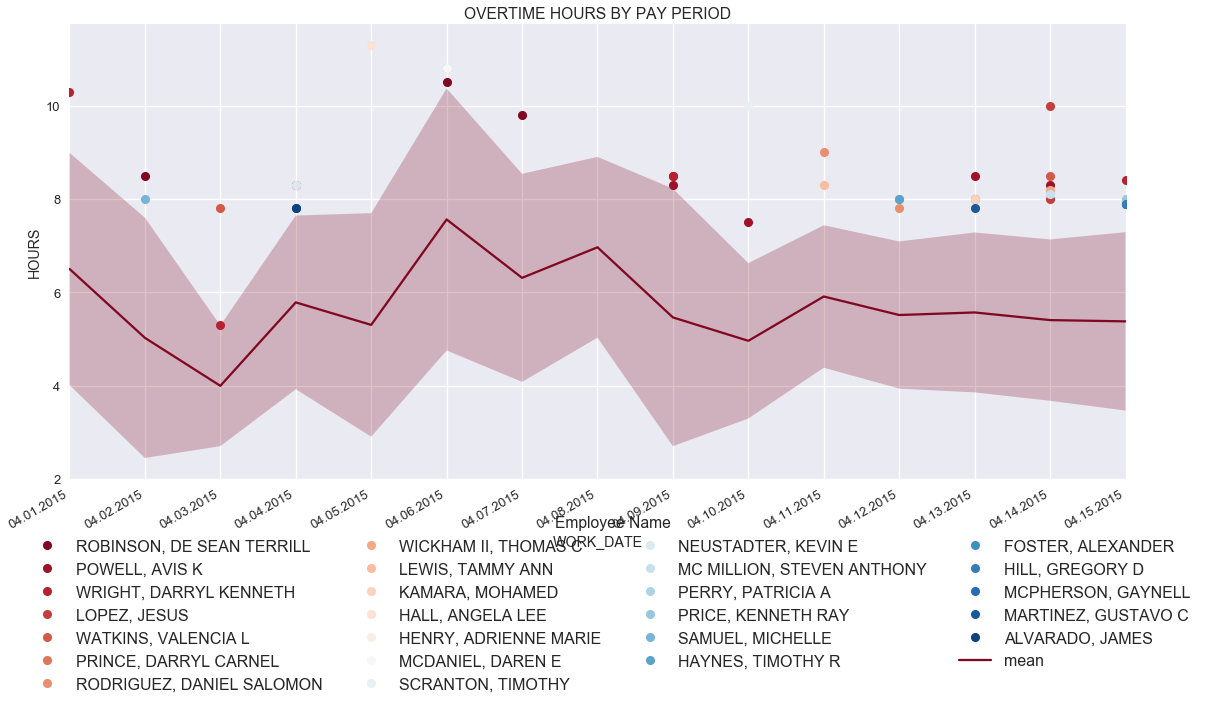

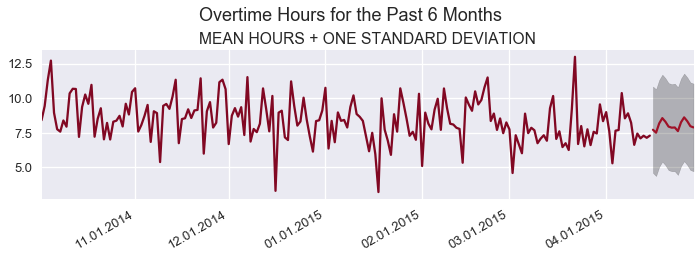

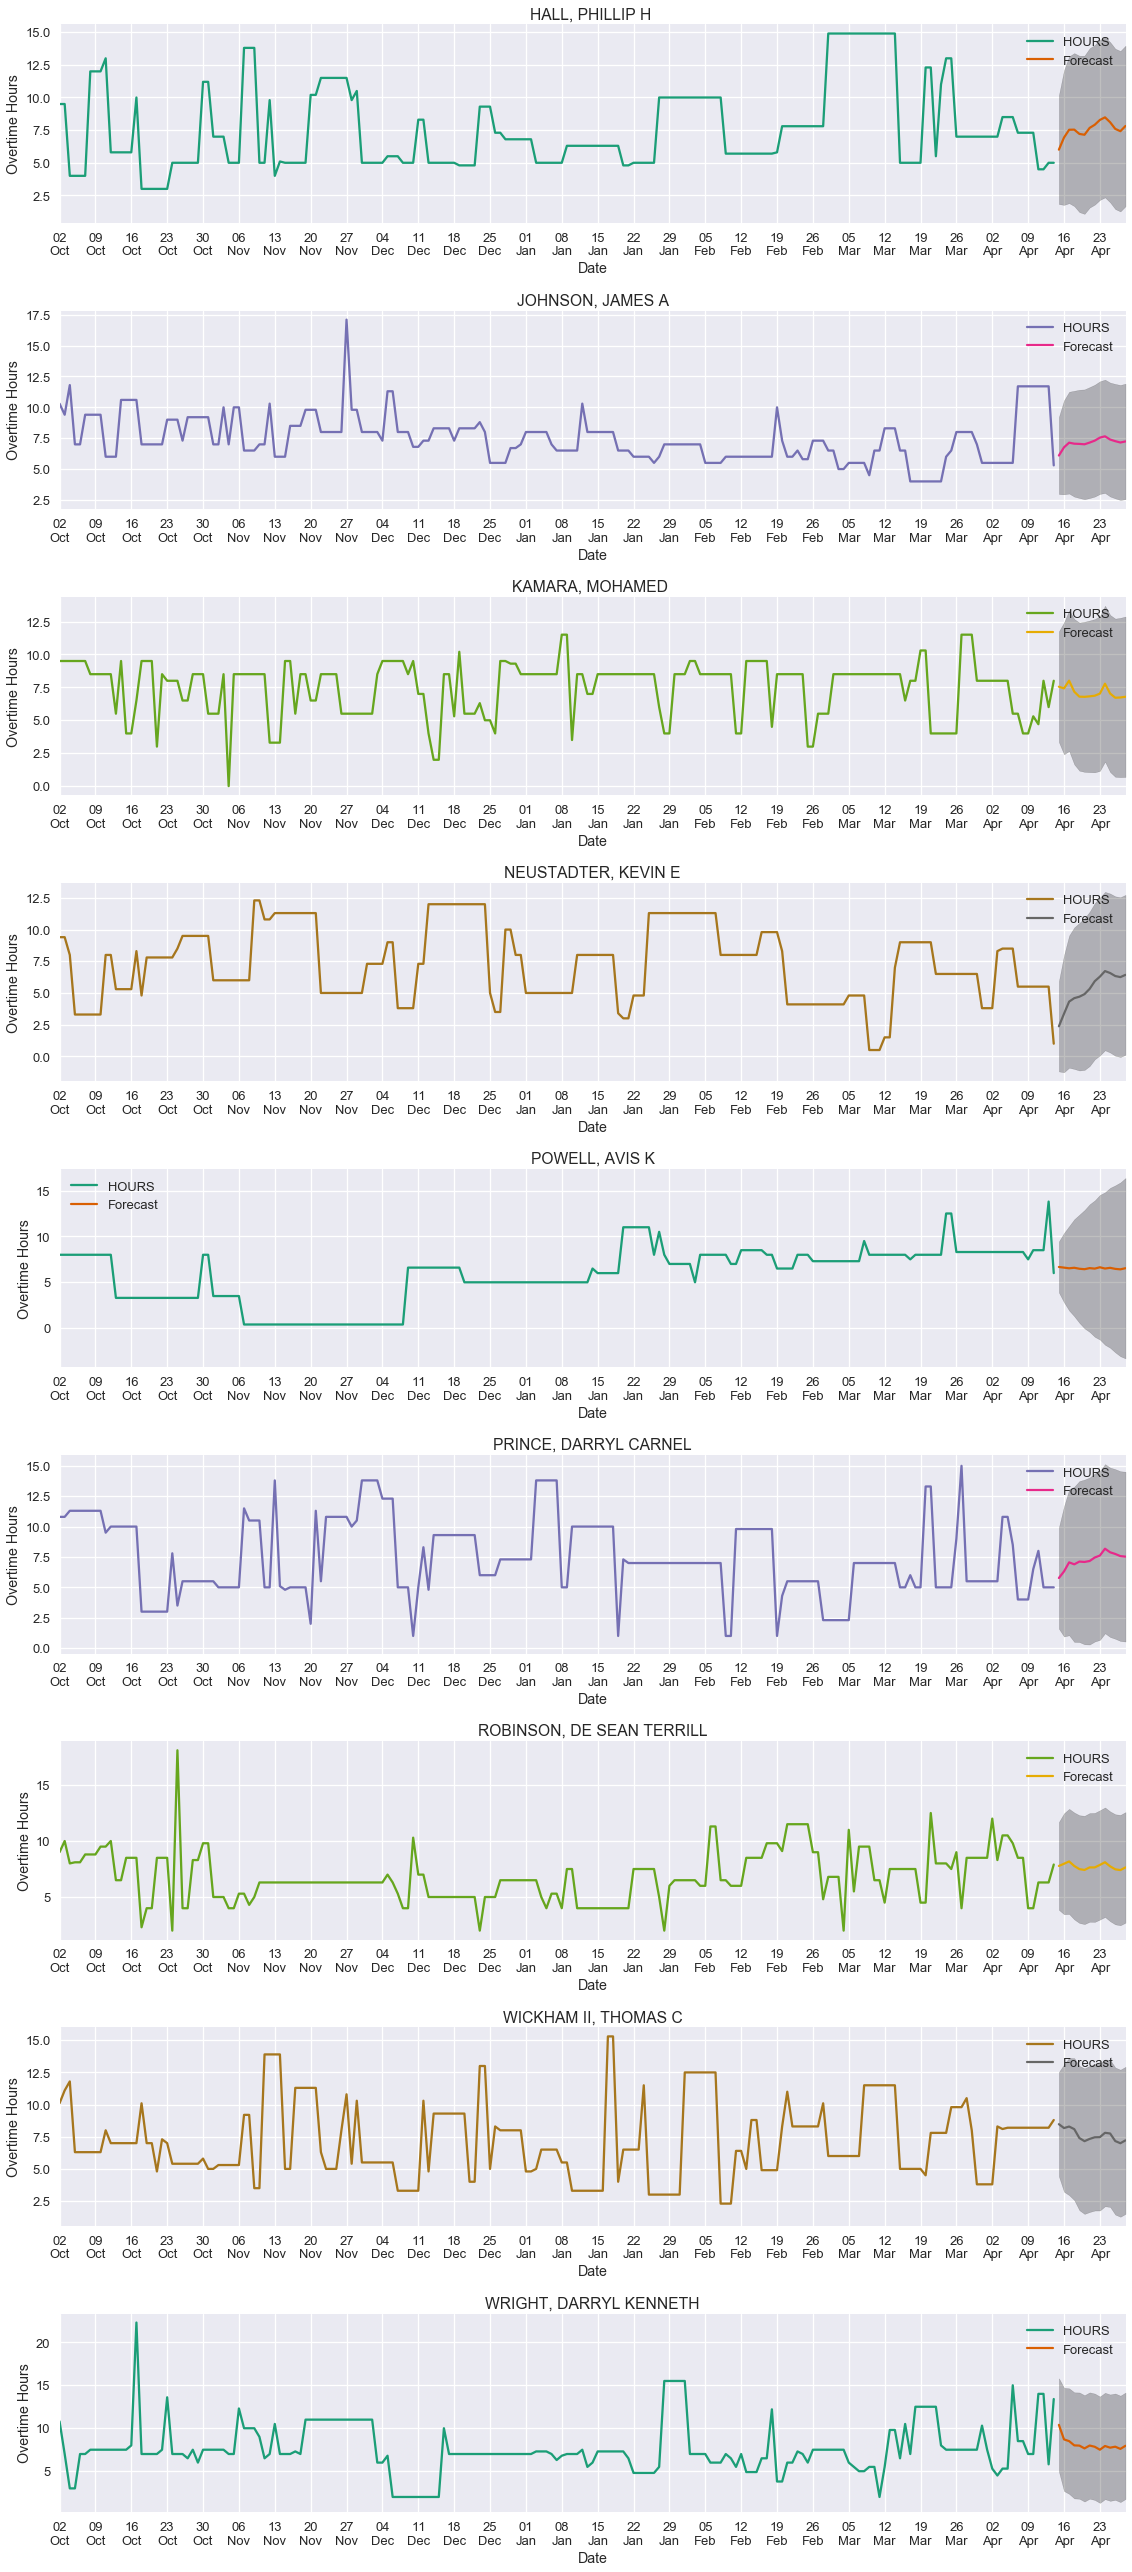

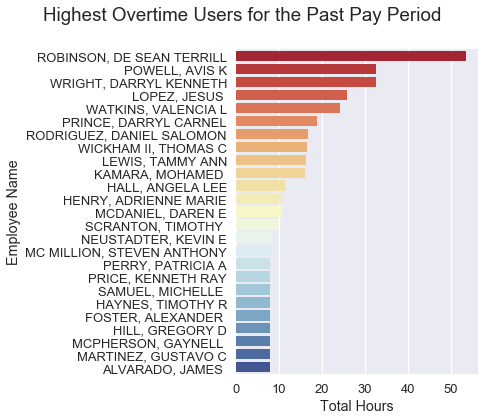

In [47]:
%%time
main()


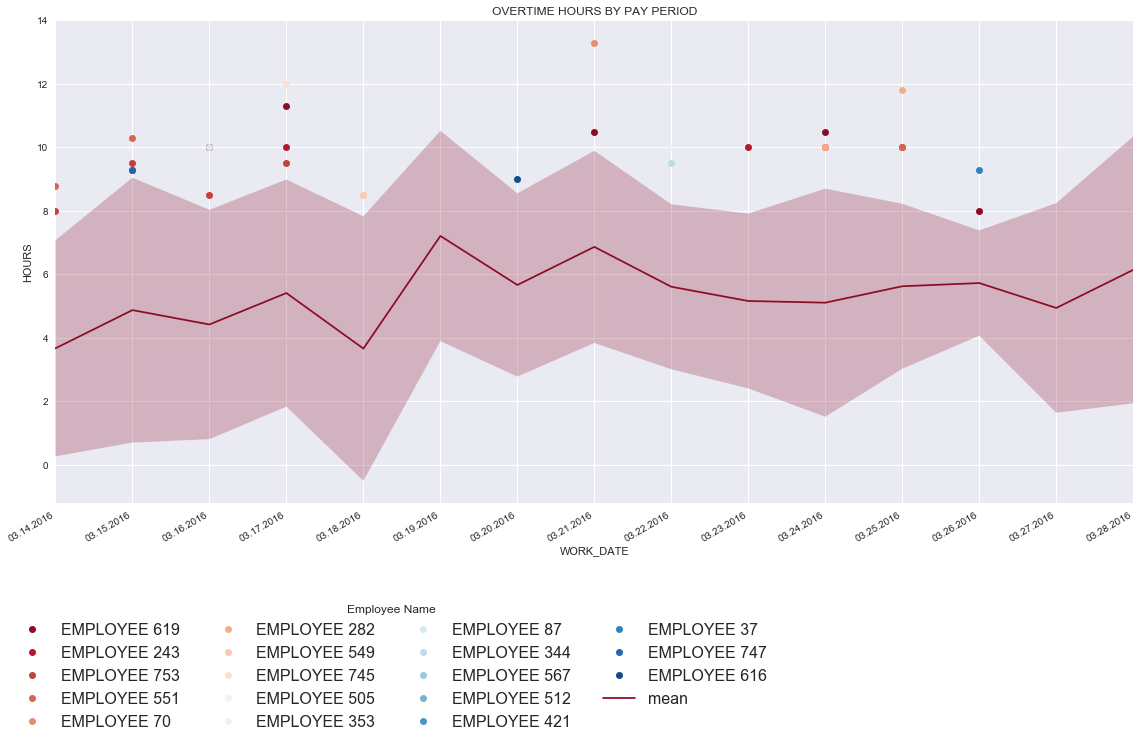

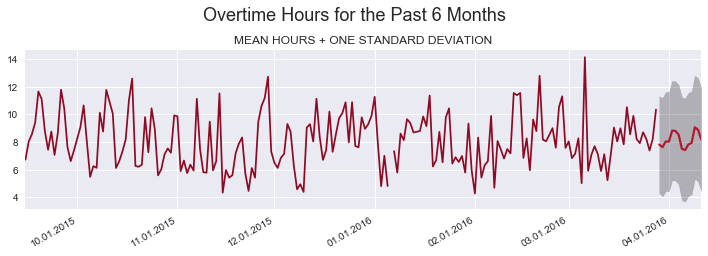

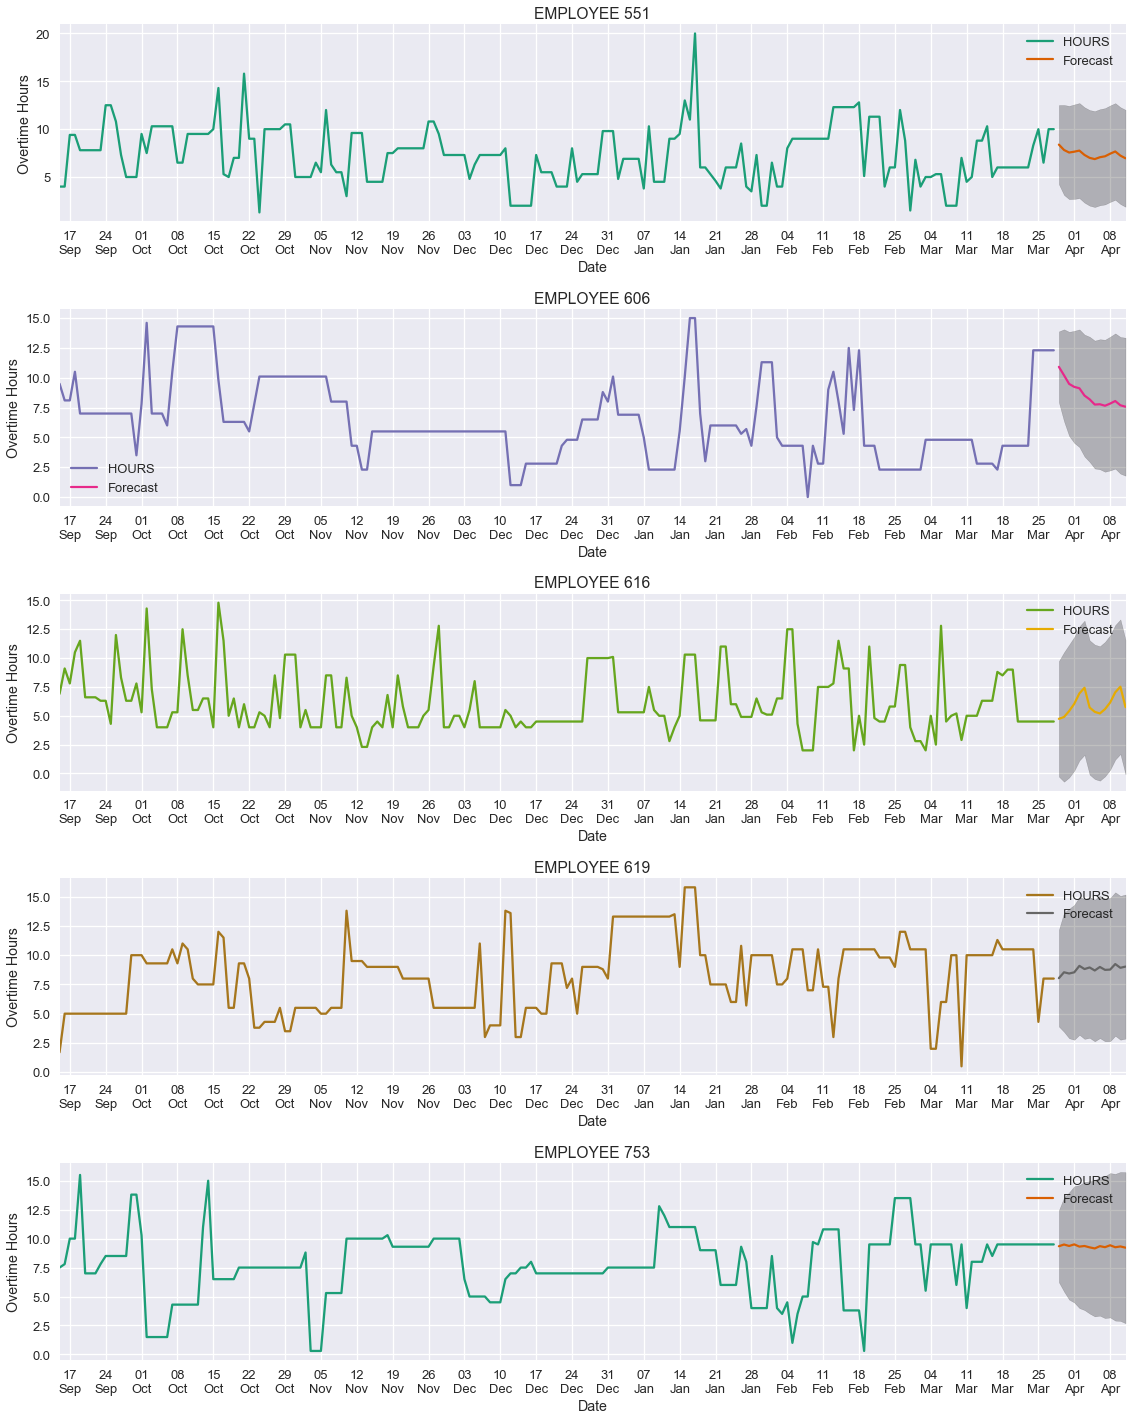

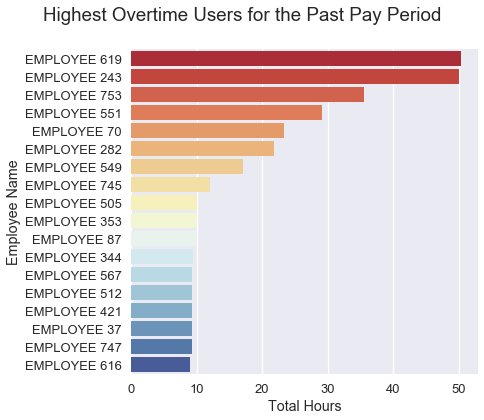

In [5]:
start_date = datetime.date(2016, 3, 14)
end_date = datetime.date(2016, 3, 28)
a = 'TRAF OFFICER II'
b = 'PA'


#use masks to create filtered dataframe, 
outlier_df = more_than_std_in_range(df, a, start_date, end_date, b)
relevant_df = get_everybody_in(df, a, start_date, end_date, b).reset_index(drop=True)
#     trend_high_list = is_trending_too_high(relevant_df)
color_names = assign_colors(outlier_df)
mean_n_outliers_plot(relevant_df, outlier_df, color_names)
# plt.savefig('means_n_outliers.png', format='png', bbox_inches='tight')
# *save_to_s3('means_n_outliers', job_title, end_date)
test_df = get_mplusstd(df, a, start_date, end_date, b)
plot_mplusstd(test_df,  order_vars =(1, 0, 1), seasonal_vars =(1, 1, 1, 7))
# plt.savefig('13mo_mean_n_total.png', format='png', bbox_inches='tight')
# *save_to_s3('13mo_mean_n_total', job_title, end_date)
increase_list = is_trending_too_high(df, relevant_df, order_vars = (1, 1, 1),
                                     seasonal_vars = (1, 1, 1, 7))
generate_plot(increase_list, end_date, df, order_vars = (1, 1, 1),
                                     seasonal_vars = (1, 1, 1, 7))
# plt.savefig('is_increasing.png', format='png', bbox_inches='tight')
# *save_to_s3('is_increasing', job_title, end_date)
plot_bars_highOT(outlier_df, color_names)
# plt.savefig('hours_dist.png', format='png', bbox_inches='tight')
# *save_to_s3('hours_dist', job_title, end_date)

In [44]:
send_email(SENDGRID_API_KEY, template_id, a, end_date)

Send email to what address?  --> melissa.petersen@lacity.org
202
b''
Server: nginx
Date: Wed, 31 May 2017 00:42:05 GMT
Content-Type: text/plain; charset=utf-8
Content-Length: 0
Connection: close
X-Message-Id: VorfXgbESXSiAOgsIDw09A
X-Frame-Options: DENY
Access-Control-Allow-Origin: https://sendgrid.api-docs.io
Access-Control-Allow-Methods: POST
Access-Control-Allow-Headers: Authorization, Content-Type, On-behalf-of, x-sg-elas-acl
Access-Control-Max-Age: 600
X-No-CORS-Reason: https://sendgrid.com/docs/Classroom/Basics/API/cors.html




CPU times: user 4.01 s, sys: 169 ms, total: 4.17 s
Wall time: 4.44 s


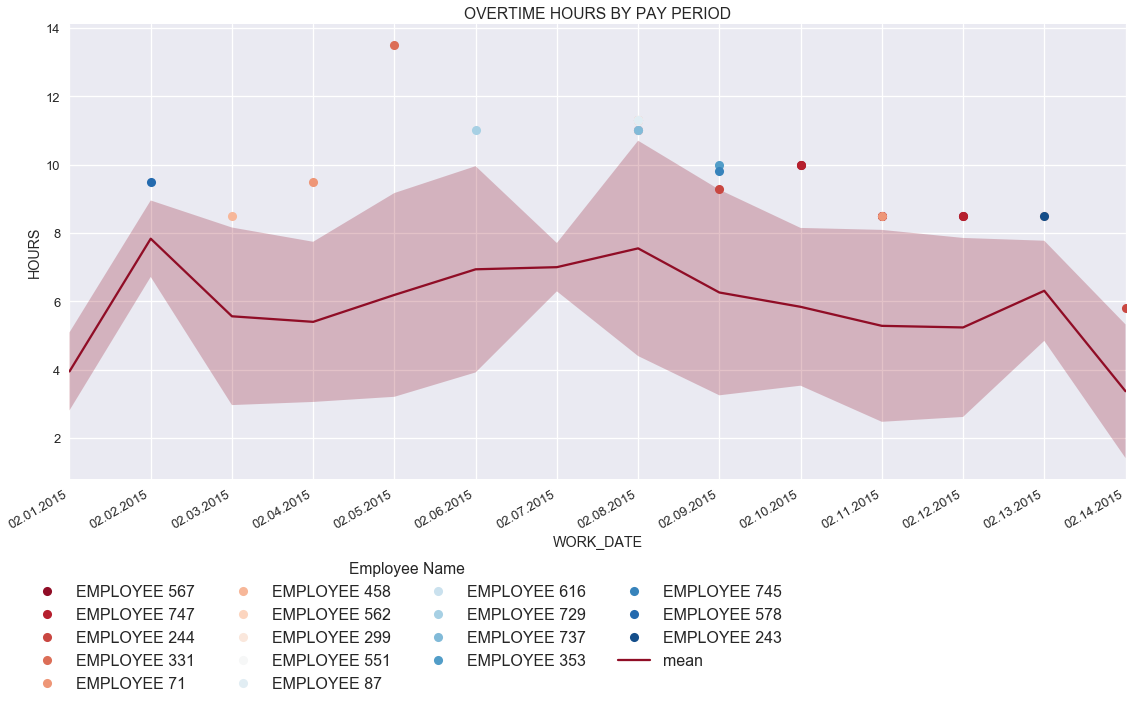

In [6]:
%%time
# import matplotlib.dates as dates


start_date = datetime.date(2015, 2, 1)
end_date = datetime.date(2015, 2, 14)
a = 'TRAF OFFICER II'
b = 'PA'


outlier_df = more_than_std_in_range(df,a, start_date, end_date, b)

relevant_df = get_everybody_in(df, a, start_date, end_date, b).reset_index(drop=True)

color_names = assign_colors(outlier_df)



mean_n_outliers_plot(relevant_df, outlier_df, color_names)
# (plot_bars_highOT(outlier_df, color_names))

CPU times: user 4.13 s, sys: 156 ms, total: 4.28 s
Wall time: 4.55 s


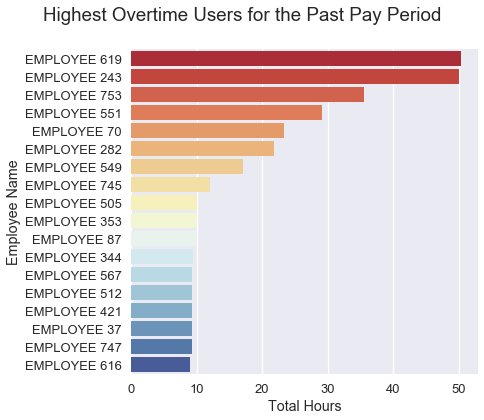

In [8]:
%%time
# import matplotlib.dates as dates


start_date = datetime.date(2016, 3, 14)
end_date = datetime.date(2016, 3, 28)
a = 'TRAF OFFICER II'
b = 'PA'


outlier_df = more_than_std_in_range(df,a, start_date, end_date, b)

relevant_df = get_everybody_in(df, a, start_date, end_date, b).reset_index(drop=True)

color_names = assign_colors(outlier_df)



(plot_bars_highOT(outlier_df, color_names))

In [29]:
%%time
# import matplotlib.dates as dates


start_date = date(2016, 3, 14)
end_date = date(2016, 3, 28)
a = 'TRAF OFFICER II'
b = 'PA'

relevant_df = get_everybody_in(df, a, start_date, end_date, b).reset_index(drop=True)
# run_analysis(df, a, start_date, end_date, b)
increase_list = is_trending_too_high(df, relevant_df, order_vars = (1, 1, 1),
                                         seasonal_vars = (1, 1, 1, 7))

# filter_increasing()

Wall time: 2min 11s


In [11]:
increase_list

['EMPLOYEE 551',
 'EMPLOYEE 606',
 'EMPLOYEE 616',
 'EMPLOYEE 619',
 'EMPLOYEE 753']

In [12]:
%%time
filter_increasing(df, increase_list, start_date, end_date, a, b)

CPU times: user 300 ms, sys: 47.6 ms, total: 348 ms
Wall time: 347 ms


['EMPLOYEE 551', 'EMPLOYEE 616', 'EMPLOYEE 619']

In [13]:
get_random_date(2016)

datetime.datetime(2016, 3, 29, 0, 0)

CPU times: user 1.06 s, sys: 157 ms, total: 1.22 s
Wall time: 1.26 s


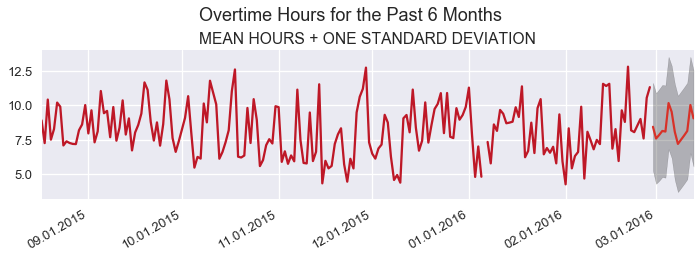

In [14]:
%%time
# import matplotlib.dates as dates


start_date = date(2016, 2, 14)
end_date = date(2016, 2, 28)
a = 'TRAF OFFICER II'
b = 'PA'



# outlier_df = more_than_std_in_range(df,a, start_date, end_date, b)

# relevant_df = get_everybody_in(df, a, start_date, end_date, b).reset_index(drop=True)

# color_names = assign_colors(outlier_df)



# mean_n_outliers_plot(relevant_df, outlier_df, color_names)

test_df = get_mplusstd(df, a, start_date, end_date, b)
plot_mplusstd(test_df, (1, 0, 1), (1, 1, 1, 7))

In [65]:
get_random_date(2015)

datetime.datetime(2015, 10, 15, 0, 0)

In [93]:
%%time
# import matplotlib.dates as dates


start_date = date(2016, 3, 1)
end_date = date(2016, 3, 14)
a = 'TRAF OFFICER II'
b = 'PA'

# relevant_df = get_everybody_in(df, a, start_date, end_date, b).reset_index(drop=True)
run_analysis(df, a, start_date, end_date, b)
# increase_list = is_trending_too_high(df, relevant_df, order_vars = (1, 0, 1),
#                                          seasonal_vars = (1, 1, 1, 7))
# generate_plot(increase_list, end_date, df, order_vars = (1, 1, 1),
#                                          seasonal_vars = (1, 1, 1, 7))

C:\Users\382365\AppData\Local\Continuum\Anaconda3\lib\site-packages\ipykernel\__main__.py:395: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate_ix


Wall time: 2min 30s


In [62]:
send_email(SENDGRID_API_KEY, template_id, a, end_date)


202
b''
Server: nginx
Date: Wed, 17 May 2017 22:53:58 GMT
Content-Type: text/plain; charset=utf-8
Content-Length: 0
Connection: close
X-Message-Id: irqZy_TIQrmW76UwkHAkUg
X-Frame-Options: DENY
Access-Control-Allow-Origin: https://sendgrid.api-docs.io
Access-Control-Allow-Methods: POST
Access-Control-Allow-Headers: Authorization, Content-Type, On-behalf-of, x-sg-elas-acl
Access-Control-Max-Age: 600
X-No-CORS-Reason: https://sendgrid.com/docs/Classroom/Basics/API/cors.html




CPU times: user 4min 26s, sys: 5.69 s, total: 4min 32s
Wall time: 4min 35s


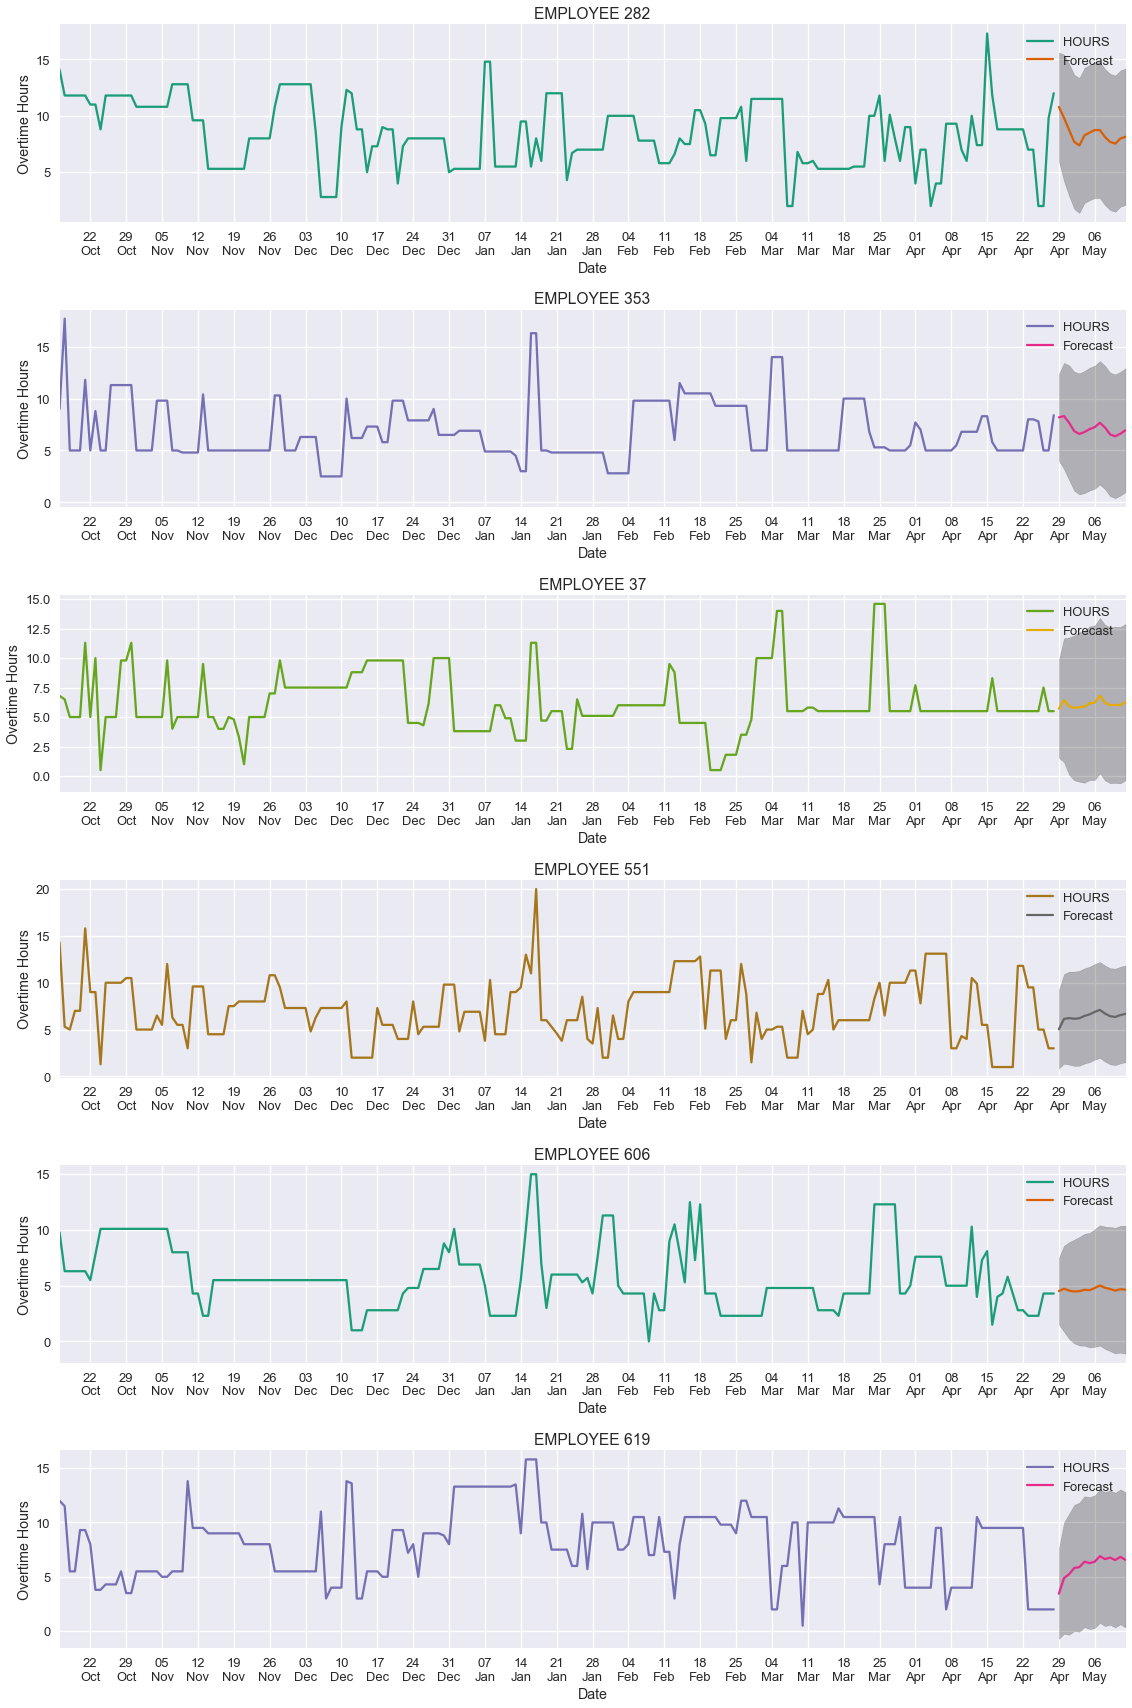

In [15]:
%%time
# import matplotlib.dates as dates


start_date = date(2016, 4, 14)
end_date = date(2016, 4, 28)
a = 'TRAF OFFICER II'
b = 'PA'

relevant_df = get_everybody_in(df, a, start_date, end_date, b).reset_index(drop=True)
# run_analysis(df, a, start_date, end_date, b)
increase_list = is_trending_too_high(df, relevant_df, order_vars = (1, 1, 1),
                                         seasonal_vars = (1, 1, 1, 7))
generate_plot(increase_list, end_date, df, order_vars = (1, 1, 1),
                                         seasonal_vars = (1, 1, 1, 7))

In [83]:
get_urls_from_s3(a, end_date)

['http://mikes-charts.s3.amazonaws.com/traf_officer_ii/20170412/20150228/13mo_mean_n_total.png',
 'http://mikes-charts.s3.amazonaws.com/traf_officer_ii/20170412/20150228/hours_dist.png',
 'http://mikes-charts.s3.amazonaws.com/traf_officer_ii/20170412/20150228/is_increasing.png',
 'http://mikes-charts.s3.amazonaws.com/traf_officer_ii/20170412/20150228/means_n_outliers.png']

In [140]:
save_to_s3('mean_ot_plot', a, end_date )

'traf_officer_ii/20170411/mean_ot_plot.png'

In [89]:
%%time
# import matplotlib.dates as dates


start_date = date(2016, 3, 14)
end_date = date(2016, 3, 28)
a = 'TRAF OFFICER II'
b = 'PA'

# month_mean_df, month_total_df = get_last_13_mos(df,a, start_date, end_date, b)
# plot_13mo_mean_n_total(month_mean_df, month_total_df)

run_analysis(df, a, start_date, end_date, b)
send_email(SENDGRID_API_KEY, template_id, a, end_date)

C:\Users\382365\AppData\Local\Continuum\Anaconda3\lib\site-packages\ipykernel\__main__.py:107: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate_ix


202
b''
Server: nginx
Date: Wed, 10 May 2017 19:28:48 GMT
Content-Type: text/plain; charset=utf-8
Content-Length: 0
Connection: close
X-Message-Id: IRvnM8GjSd-LZ3bwMS9gyA
X-Frame-Options: DENY
Access-Control-Allow-Origin: https://sendgrid.api-docs.io
Access-Control-Allow-Methods: POST
Access-Control-Allow-Headers: Authorization, Content-Type, On-behalf-of, x-sg-elas-acl
Access-Control-Max-Age: 600
X-No-CORS-Reason: https://sendgrid.com/docs/Classroom/Basics/API/cors.html


Wall time: 2min 55s


In [20]:
start_date = date(2015, 6, 1)
end_date = date(2015, 6, 15)

a = 'TRAF OFFICER II'
b = 'PA'
outlier_df = more_than_std_in_range(df,a, start_date, end_date, b)

outlier_df.head(10)

,WORK_DATE,EMPLOYEE_NAME,HOURS
0,2015-06-04,EMPLOYEE 353,9.0
1,2015-06-05,EMPLOYEE 299,7.5
2,2015-06-05,EMPLOYEE 331,7.5
3,2015-06-05,EMPLOYEE 599,7.8
4,2015-06-06,EMPLOYEE 310,9.0
5,2015-06-06,EMPLOYEE 331,8.3
6,2015-06-06,EMPLOYEE 459,8.5
7,2015-06-06,EMPLOYEE 551,8.5
8,2015-06-07,EMPLOYEE 726,13.8
9,2015-06-08,EMPLOYEE 292,13.8


In [141]:


mod = sm.tsa.statespace.SARIMAX(jobclass_mstd,
                                order=(4, 0, 1),
                                seasonal_order=(1, 1, 1, 7),
                                enforce_stationarity=False,
                                enforce_invertibility=False)

results = mod.fit()

print(results.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.8404      0.111      7.587      0.000       0.623       1.058
ar.L2         -0.0345      0.085     -0.408      0.683      -0.200       0.131
ar.L3         -0.3219      0.025    -12.769      0.000      -0.371      -0.273
ar.L4          0.2282      0.024      9.493      0.000       0.181       0.275
ma.L1         -0.0651      0.115     -0.567      0.571      -0.290       0.160
ar.S.L7        0.0126      0.014      0.876      0.381      -0.016       0.041
ma.S.L7       -1.0027      0.014    -72.298      0.000      -1.030      -0.976
sigma2         0.6542      0.018     36.640      0.000       0.619       0.689


In [142]:
results.aic

4680.4093190626554

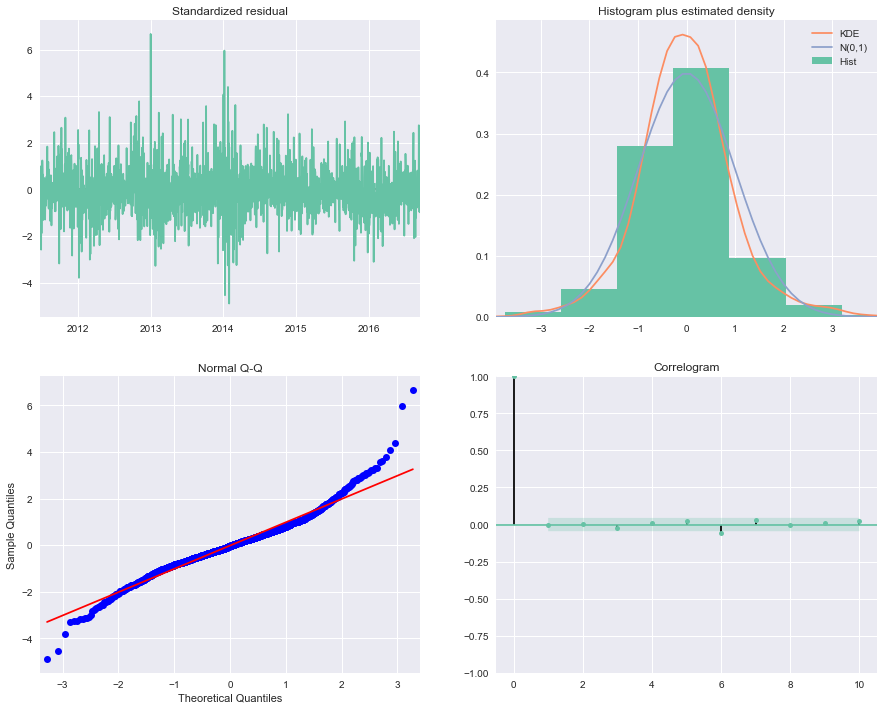

In [143]:
results.plot_diagnostics(figsize=(15, 12))
plt.show()

In [89]:
# Extract the predicted and true values of our time series
y_forecasted = pred_dynamic.predicted_mean
y_truth = jobclass_mstd['2016-01-01':]

# Compute the mean square error
mse = ((y_forecasted - y_truth) ** 2).mean()
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))


The Mean Squared Error of our forecasts is 1.31


In [167]:
y_forecasted = pred.predicted_mean
y_truth = yolanda_df['HOURS']['2016-03-01':]

# Compute the mean square error
mse = ((y_forecasted - y_truth) ** 2).mean()
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))

The Mean Squared Error of our forecasts is 13.17


(0, 370)

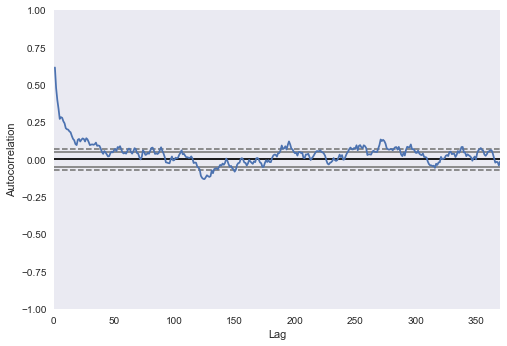

In [87]:
pd.tools.plotting.autocorrelation_plot(better_df['HOURS'])
# plt.axis([0, 90, -1, 1])
plt.xlim(0, 370)

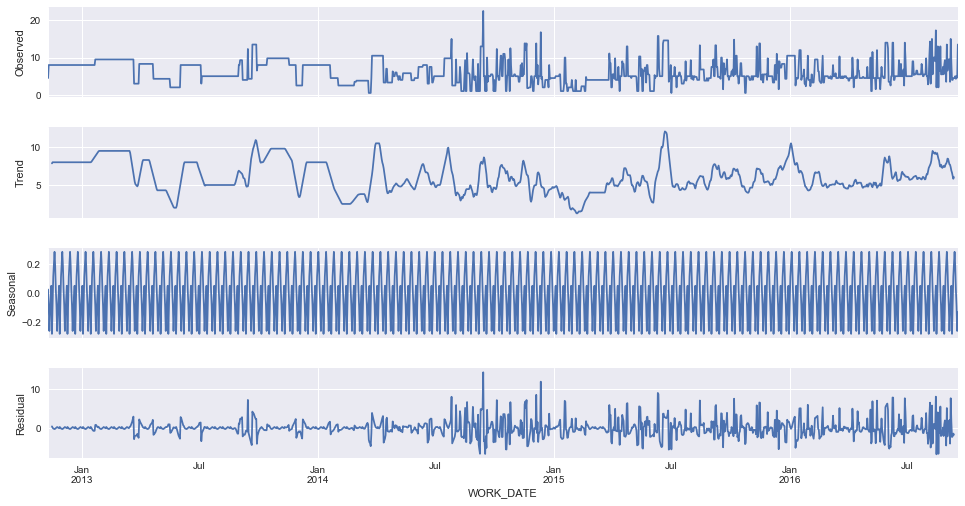

In [37]:
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller


decomposition = seasonal_decompose(better_df['HOURS'], freq=12)  
fig = plt.figure()  
fig = decomposition.plot()  
fig.set_size_inches(15, 8)

In [102]:
from statsmodels.tsa.arima_model import ARIMA

model = ARIMA(better_df['HOURS'], order=(5,1,0))
model_fit = model.fit(disp=0)
print(model_fit.summary())

                             ARIMA Model Results                              
Dep. Variable:                D.HOURS   No. Observations:                 1407
Model:                 ARIMA(5, 1, 0)   Log Likelihood               -3227.320
Method:                       css-mle   S.D. of innovations              2.398
Date:                Fri, 14 Apr 2017   AIC                           6468.641
Time:                        09:41:51   BIC                           6505.385
Sample:                    11-11-2012   HQIC                          6482.373
                         - 09-17-2016                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0015      0.028      0.053      0.957      -0.054       0.057
ar.L1.D.HOURS    -0.4330      0.026    -16.397      0.000      -0.485      -0.381
ar.L2.D.HOURS    -0.2983      0.029    -

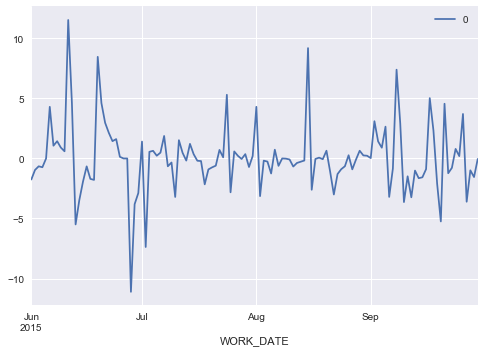

In [115]:
# plot residual errors
residuals = pd.DataFrame(model_fit.resid)
residuals['2015-06':'2015-09'].plot()

plt.show()

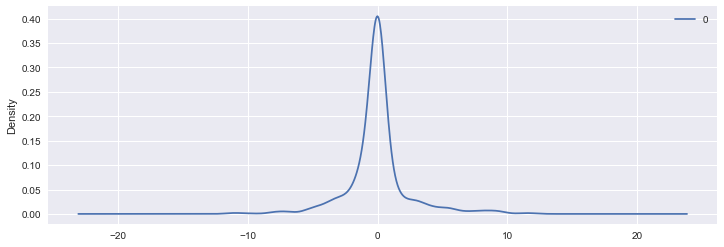

                 0
count  1407.000000
mean      0.002236
std       2.399299
min     -11.348915
25%      -0.603297
50%      -0.003423
75%       0.256268
max      12.117079


In [131]:
residuals.plot(kind='kde')
plt.show()
print(residuals.describe())

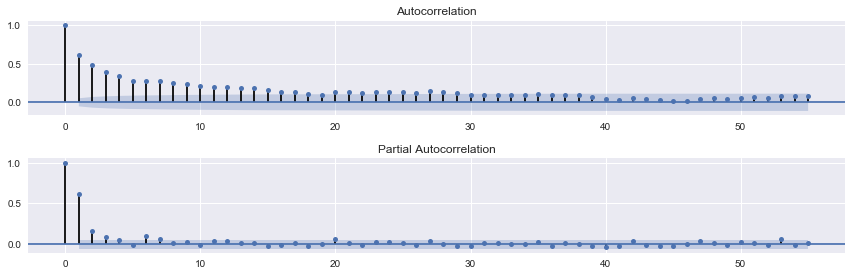

In [129]:


# Autocorrelation tests for seasonal stationarity
# Plot the autocorrelation and the partial autocorrelation
test_acfs(better_df['HOURS'], 55)

